# Домашнее задание №7
*Задание выполнил* **Чащин Артем Максимович**

*Курс:* **3**, *группа:* **МФТИ-1**

**[GitHub](https://github.com/alexvilno/PSU_TIMESERIES/tree/HW2)**

**[Telegram](https://t.me/artemchashchin)**

## Оглавление
* [Генерим 21 сигналов (временных рядов), 3 класса по 7 образцов в каждом.](#1)
* [Рассчитываем расстояние между ними по формуле Евклида и с помощью DTW, описываем кратко полученные значения](#2)
* [Формируем из нагенеренных временных рядов набор данных для обучения](#3)
* [Разбиваем набор на train и test](#4)
* [Обучаем классификаторы KNN с DTW, KNN со стандартной метрикой расстояния, TimeSeriesForest](#5)



### Генерим 21 сигналов (временных рядов), 3 класса по 7 образцов в каждом. <a id="1"></a>

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import random

myseed = 13072003
random.seed(myseed)
np.random.seed(myseed)

Функции, которые мне нужны для генерации и визуализации временных рядов

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def tanh(x: np.ndarray) -> np.ndarray:
    """Вычисляет гиперболический тангенс элементов массива x.

    Аргументы:
    x (np.ndarray): Входной массив.

    Возвращает:
    np.ndarray: Массив, содержащий результаты вычисления гиперболического тангенса для каждого элемента входного массива.

    Raises:
    ValueError: Если `x` не является массивом.

    """
    if not isinstance(x, np.ndarray):
        raise ValueError("Аргумент 'x' должен быть массивом.")

    return np.tanh(x)

In [52]:
def generate_timeseries(time: np.ndarray, num_series: int) -> dict:
    """Генерирует временные ряды различных типов и возвращает их в виде словаря.

    Аргументы:
    time (np.ndarray): Входной массив значений времени.
    num_series (int): Количество временных рядов для генерации.

    Возвращает:
    dict: Словарь, содержащий сгенерированные временные ряды.

    Raises:
    ValueError: Если `time` не является одномерным массивом.
    ValueError: Если `num_series` меньше или равно нулю.

    """
    if len(time.shape) != 1:
        raise ValueError("Аргумент 'time' должен быть одномерным массивом.")

    if num_series <= 0:
        raise ValueError("Аргумент 'num_series' должен быть положительным числом.")

    timeseries = {'time': time}
    rand = np.random.random(size=num_series)

    for i in range(num_series):
        timeseries[f'harmonical{i}'] = -0.5 * (1 - rand[i] / 100)  * np.cos(np.pi * 0.2 * time + rand[i]) * (1 + rand[i] * 0.2)
        
    for i in range(num_series):
        timeseries[f'sin{i}'] = 0.5 * (1 - rand[i] / 100) * np.sin(time + rand[i] + 0.3) * (1 + rand[i] * 0.2)
        
    for i in range(num_series):
        timeseries[f'tanh{i}'] = -0.5 * (1 - rand[i] / 100) * np.tanh(time + rand[i] * 1.5 - 2.2) * (1 + rand[i] * 0.2)

    
    return timeseries

In [53]:
def plot_timeseries(timeseries: dict, num_series: int) -> None:
    """Отображает временные ряды на графике.

    Аргументы:
    timeseries (dict): Словарь, содержащий временные ряды. Ключ 'time' должен содержать массив значений времени.
    num_series (int): Количество временных рядов для отображения.

    Возвращает:
    None

    Raises:
    ValueError: Если `timeseries` не является словарем.
    ValueError: Если ключ 'time' отсутствует в словаре `timeseries`.
    ValueError: Если `num_series` меньше или равно нулю.

    """
    if not isinstance(timeseries, dict):
        raise ValueError("Аргумент 'timeseries' должен быть словарем.")

    if 'time' not in timeseries:
        raise ValueError("Ключ 'time' отсутствует в словаре 'timeseries'.")

    if num_series <= 0:
        raise ValueError("Аргумент 'num_series' должен быть положительным числом.")

    colors = ['-b', '-g', '-r', '-c', '-m', '-y', '-k']
    plt.figure(figsize=(10, 5))
    for key in timeseries:
        if key != 'time':
            series_label = f'{key}'
            plt.plot(timeseries['time'], timeseries[key], label=series_label)
    
    plt.legend()
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.title('Графики временных рядов')
    plt.grid(True)
    plt.show()

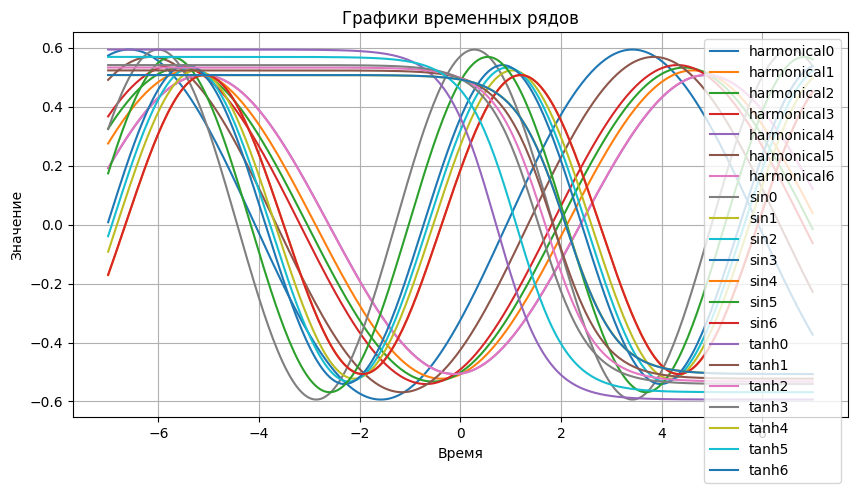

In [54]:
time = np.linspace(-7, 7, num=300)
num_series = 7
timeseries = generate_timeseries(time, num_series)
plot_timeseries(timeseries, num_series)

### Рассчитываем расстояние между ними по формуле Евклида и с помощью DTW, описываем кратко полученные значения <a id="2"> </a>

In [55]:
from scipy.spatial.distance import euclidean
from typing import Dict, Any, Type
from dtaidistance import dtw
from enum import Enum

class DistanceMetric(Enum):
    EUCLIDEAN = "euclidean"
    DTW = "dtw"


def calculate_distances(timeseries: Dict[str, Any], distance_metric: DistanceMetric) -> np.ndarray:
    """Вычисляет расстояния между временными рядами в соответствии с выбранной метрикой расстояния.

    Аргументы:
    timeseries (Dict[str, Any]): Словарь, содержащий временные ряды.
    distance_metric (DistanceMetric): Выбранная метрика расстояния (euclidean или dtw).

    Возвращает:
    np.ndarray: Массив расстояний.

    Raises:
    ValueError: Если выбрана недопустимая метрика расстояния.
    Exception: Если возникает ошибка при вычислении расстояний.
    """

    distances = []
    dtw_dist = np.array([])

    try:
        for i in range(1, 4):
            x = np.abs(timeseries[f"sin{i}"])
            y = np.abs(timeseries[f"sin{i - 1}"])
            if distance_metric == DistanceMetric.EUCLIDEAN:
                distance = euclidean(x, y)
            elif distance_metric == DistanceMetric.DTW:
                distance = dtw.distance(x, y)
                dtw_dist = np.append(dtw_dist, distance)
            else:
                raise ValueError("Invalid distance metric. Choose 'euclidean' or 'dtw'.")
            
            distances.append(distance)
            print(f"Расстояние {distance_metric.value} для sin{i} и {7 - i}: {distance}")

        for i in range(1, 4):
            x = np.abs(timeseries[f"harmonical{i}"])
            y = np.abs(timeseries[f"harmonical{i - 1}"])
            if distance_metric == DistanceMetric.EUCLIDEAN:
                distance = euclidean(x, y)
            elif distance_metric == DistanceMetric.DTW:
                distance = dtw.distance(x, y)
                dtw_dist = np.append(dtw_dist, distance)
            else:
                raise ValueError("Invalid distance metric. Choose 'euclidean' or 'dtw'.")
            
            distances.append(distance)
            print(f"Расстояние {distance_metric.value} для harmonical{i} и {7 - i}: {distance}")

        for i in range(1, 4):
            x = np.abs(timeseries[f"tanh{i}"])
            y = np.abs(timeseries[f"tanh{i - 1}"])
            if distance_metric == DistanceMetric.EUCLIDEAN:
                distance = euclidean(x, y)
            elif distance_metric == DistanceMetric.DTW:
                distance = dtw.distance(x, y)
                dtw_dist = np.append(dtw_dist, distance)
            else:
                raise ValueError("Invalid distance metric. Choose 'euclidean' or 'dtw'.")
            
            distances.append(distance)
            print(f"Расстояние {distance_metric.value} для tanh{i} и {7 - i}: {distance}")

        x = np.abs(timeseries["sin1"])
        y = np.abs(timeseries["harmonical1"])
        if distance_metric == DistanceMetric.EUCLIDEAN:
            distance = euclidean(x, y)
        elif distance_metric == DistanceMetric.DTW:
            distance = dtw.distance(x, y)
            dtw_dist = np.append(dtw_dist, distance)
        else:
            raise ValueError("Invalid distance metric. Choose 'euclidean' or 'dtw'.")
        
        distances.append(distance)
        print(f"Расстояние {distance_metric.value} для sin1 и harmonical1: {distance}")

        x = np.abs(timeseries["tanh1"])
        y = np.abs(timeseries["harmonical1"])
        if distance_metric == DistanceMetric.EUCLIDEAN:
            distance = euclidean(x, y)
        elif distance_metric == DistanceMetric.DTW:
            distance = dtw.distance(x, y)
            dtw_dist = np.append(dtw_dist, distance)
        else:
            raise ValueError("Invalid distance metric. Choose 'euclidean' or 'dtw'.")
        
        distances.append(distance)
        print(f"Расстояние {distance_metric.value} для tanh1 и harmonical1: {distance}")

        x = np.abs(timeseries["tanh1"])
        y = np.abs(timeseries["sin1"])
        if distance_metric == DistanceMetric.EUCLIDEAN:
            distance = euclidean(x, y)
        elif distance_metric == DistanceMetric.DTW:
            distance = dtw.distance(x, y)
            dtw_dist = np.append(dtw_dist, distance)
        else:
            raise ValueError("Invalid distance metric. Choose 'euclidean' or 'dtw'.")
        
        distances.append(distance)
        print(f"Расстояние {distance_metric.value} для tanh1 и sin1: {distance}")

        if distance_metric == DistanceMetric.DTW:
            return np.array(dtw_dist)
        else:
            return np.array(distances)
    except Exception as err:
        raise err

Расчитаем Евклидовы расстояния

In [56]:
distances_euclidean = calculate_distances(timeseries, DistanceMetric.EUCLIDEAN)

Расстояние euclidean для sin1 и 6: 4.317654624519235
Расстояние euclidean для sin2 и 5: 0.6765237891505248
Расстояние euclidean для sin3 и 4: 0.5915108727305414
Расстояние euclidean для harmonical1 и 6: 4.060872944422168
Расстояние euclidean для harmonical2 и 5: 0.6418844612858491
Расстояние euclidean для harmonical3 и 4: 0.5626879217021523
Расстояние euclidean для tanh1 и 6: 2.574454142818025
Расстояние euclidean для tanh2 и 5: 0.44534723750635646
Расстояние euclidean для tanh3 и 4: 0.3911604218518431
Расстояние euclidean для sin1 и harmonical1: 3.69347972005812
Расстояние euclidean для tanh1 и harmonical1: 3.266092519203313
Расстояние euclidean для tanh1 и sin1: 4.278839081599525


Расчитаем расстояния DTW

In [57]:
distances_dtw = calculate_distances(timeseries, DistanceMetric.DTW)

Расстояние dtw для sin1 и 6: 1.0714547112596562
Расстояние dtw для sin2 и 5: 0.11760184002467207
Расстояние dtw для sin3 и 4: 0.08794485016482205
Расстояние dtw для harmonical1 и 6: 1.3058547963562257
Расстояние dtw для harmonical2 и 5: 0.11076685481541493
Расстояние dtw для harmonical3 и 4: 0.10212862218902317
Расстояние dtw для tanh1 и 6: 1.0221663118633078
Расстояние dtw для tanh2 и 5: 0.1326465470997748
Расстояние dtw для tanh3 и 4: 0.11232174500153418
Расстояние dtw для sin1 и harmonical1: 1.9418462793844995
Расстояние dtw для tanh1 и harmonical1: 2.454421382674944
Расстояние dtw для tanh1 и sin1: 2.877960135350837


In [58]:
print (f"Евклидова метрика больше DTW в среднем на: {(distances_euclidean - distances_dtw).mean()}")

Евклидова метрика больше DTW в среднем на: 1.1802828050552454


Eсли важно учесть временную структуру и обнаружить сдвиги и искажения, DTW может предоставить более точные результаты.

### Формируем из нагенеренных временных рядов набор данных для обучения <a id="3"> </a>

In [59]:
from typing import List, Tuple

def convert_to_class_dataset(timeseries: dict, ts_num: int) -> Tuple[List[np.ndarray], List[int]]:
    """Преобразует результаты функции generate_timeseries в формат, аналогичный описанному коду.

    Аргументы:
    timeseries (dict): Словарь, содержащий сгенерированные временные ряды.
    ts_num (int): Количество временных рядов.

    Возвращает:
    tuple: Кортеж, содержащий временные ряды и соответствующие классы.

    Raises:
    ValueError: Если количество временных рядов (`ts_num`) превышает доступные ряды в `timeseries`.
    """

    class_data = []
    class_nums = []

    for idx in range(ts_num):
        key = f'sin{idx}'
        if key not in timeseries:
            raise ValueError(f"Временный ряд '{key}' не найден в timeseries.")
        class_data.append(timeseries[key])
        class_nums.append(1)

    for idx in range(ts_num):
        key = f'harmonical{idx}'
        if key not in timeseries:
            raise ValueError(f"Временный ряд '{key}' не найден в timeseries.")
        class_data.append(timeseries[key])
        class_nums.append(2)

    for idx in range(ts_num):
        key = f'tanh{idx}'
        if key not in timeseries:
            raise ValueError(f"Временный ряд '{key}' не найден в timeseries.")
        class_data.append(timeseries[key])
        class_nums.append(3)

    return class_data, class_nums

In [60]:
class_data, class_nums = convert_to_class_dataset(timeseries, num_series)

### Разбиваем набор на train и test <a id="4"> </a>

In [61]:
from typing import List, Tuple

def split_dataset(class_data: List[np.ndarray], class_nums: List[int], test_ratio: float) -> Tuple[List[np.ndarray], List[np.ndarray], List[int], List[int]]:
    """Разделяет набор данных на тренировочный и тестовый наборы.

    Аргументы:
    class_data (List[np.ndarray]): Список с данными для каждого класса.
    class_nums (List[int]): Список с метками классов для каждого элемента данных.

    Возвращает:
    Tuple[List[np.ndarray], List[np.ndarray], List[int], List[int]]: Кортеж с тренировочными и тестовыми данными и соответствующими метками классов.

    Raises:
    ValueError: Если длина `class_data` и `class_nums` не совпадает или набор данных пуст.

    """
    if len(class_data) != len(class_nums) or len(class_data) == 0:
        raise ValueError("Некорректные входные данные. Длина class_data и class_nums должна совпадать и не должна быть нулевой.")
    try:
        arr = np.arange(len(class_nums))
        np.random.shuffle(arr)

        train_indices = arr[:int(-len(arr) * test_ratio)]
        test_indices = arr[len(train_indices):]

        X_train = [class_data[i] for i in train_indices]
        X_test = [class_data[i] for i in test_indices]
        y_train = [class_nums[i] for i in train_indices]
        y_test = [class_nums[i] for i in test_indices]

        return X_train, X_test, y_train, y_test
    except Exception as err:
        raise err

Разбиваем датасет на train и test

In [62]:
X_train, X_test, y_train, y_test = split_dataset(class_data=class_data, class_nums=class_nums, test_ratio=0.25)

### Обучаем классификаторы KNN с DTW, KNN со стандартной метрикой расстояния, TimeSeriesForest <a id="5"> </a>

Обучаем классификатор по метрике DTW

In [63]:
# dtw метрика
from pyts.classification import KNeighborsClassifier

clf = KNeighborsClassifier(metric='dtw')
clf.fit(X_train, y_train)

print(f"Accuracy {clf.score(X_test, y_test)}")
for i in range(len(y_test)):
    print(f"{i + 1} объект:")
    print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[i].reshape(1, -1))}")
    print(f"Истинный класс для предсказаний {y_test[i]}")

Accuracy 1.0
1 объект:
Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 3
2 объект:
Вектор вероятности принадлежности к классам [[1. 0. 0.]]
Истинный класс для предсказаний 1
3 объект:
Вектор вероятности принадлежности к классам [[0. 1. 0.]]
Истинный класс для предсказаний 2
4 объект:
Вектор вероятности принадлежности к классам [[0. 1. 0.]]
Истинный класс для предсказаний 2
5 объект:
Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 3


Обучаем классификатор по метрике DTW

In [64]:
# стандартная метрика
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

print(f"Accuracy {clf.score(X_test, y_test)}")
for i in range(len(y_test)):
    print(f"{i + 1} объект:")
    print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[i].reshape(1, -1))}")
    print(f"Истинный класс для предсказаний {y_test[i]}")

Accuracy 1.0
1 объект:
Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 3
2 объект:
Вектор вероятности принадлежности к классам [[1. 0. 0.]]
Истинный класс для предсказаний 1
3 объект:
Вектор вероятности принадлежности к классам [[0. 1. 0.]]
Истинный класс для предсказаний 2
4 объект:
Вектор вероятности принадлежности к классам [[0. 1. 0.]]
Истинный класс для предсказаний 2
5 объект:
Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 3


Обучим модель TSForest

In [65]:
# лес
from pyts.classification import TimeSeriesForest
 
clf = TimeSeriesForest(random_state=43)
clf.fit(X_train, y_train)


print(f"Accuracy {clf.score(X_test, y_test)}")
for i in range(len(y_test)):
    print(f"{i + 1} объект:")
    print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[i].reshape(1, -1))}")
    print(f"Истинный класс для предсказаний {y_test[i]}")

Accuracy 1.0
1 объект:
Вектор вероятности принадлежности к классам [[0.018 0.026 0.956]]
Истинный класс для предсказаний 3
2 объект:
Вектор вероятности принадлежности к классам [[0.702 0.122 0.176]]
Истинный класс для предсказаний 1
3 объект:
Вектор вероятности принадлежности к классам [[0.042 0.944 0.014]]
Истинный класс для предсказаний 2
4 объект:
Вектор вероятности принадлежности к классам [[0.206 0.74  0.054]]
Истинный класс для предсказаний 2
5 объект:
Вектор вероятности принадлежности к классам [[0.01  0.002 0.988]]
Истинный класс для предсказаний 3


Все классификаторы отлично справились с задачей